In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
from scipy.stats import beta
from scipy.integrate import quad
import arviz as az

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

In [3]:
SEED = 42  # Scegli un valore per il seed
np.random.seed(SEED)
data = np.random.normal(loc=5, scale=2, size=100)
print(data)

[ 5.99342831  4.7234714   6.29537708  8.04605971  4.53169325  4.53172609
  8.15842563  6.53486946  4.06105123  6.08512009  4.07316461  4.06854049
  5.48392454  1.17343951  1.55016433  3.87542494  2.97433776  5.62849467
  3.18395185  2.1753926   7.93129754  4.5484474   5.13505641  2.15050363
  3.91123455  5.22184518  2.69801285  5.75139604  3.79872262  4.4166125
  3.79658678  8.70455637  4.97300555  2.88457814  6.64508982  2.5583127
  5.41772719  1.08065975  2.3436279   5.39372247  6.47693316  5.34273656
  4.76870344  4.39779261  2.04295602  3.56031158  4.07872246  7.11424445
  5.68723658  1.47391969  5.64816794  4.22983544  3.646156    6.22335258
  7.06199904  6.86256024  3.32156495  4.38157525  5.66252686  6.95109025
  4.04165152  4.62868205  2.78733005  2.60758675  6.62505164  7.71248006
  4.85597976  7.0070658   5.72327205  3.70976049  5.72279121  8.07607313
  4.92834792  8.12928731 -0.23949021  6.64380501  5.17409414  4.4019853
  5.18352155  1.02486217  4.56065622  5.71422514  7.95

In [4]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data)
    # Sampling from the posterior
    trace = pm.sampling_jax.sample_numpyro_nuts(1000)
    # Generating posterior predictive samples
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["y"]
    )

Compiling...


Compilation time = 0:00:01.414441


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1635.88it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1637.31it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1639.25it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1640.75it/s]


Sampling time = 0:00:01.544473


Transforming variables...


Transformation time = 0:00:00.059700


Sampling: [y]


In [5]:
with model:
    pm.compute_log_likelihood(trace)

In [6]:
loo_result = az.loo(trace, pointwise=True)
print(loo_result)

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -202.93     6.85
p_loo        1.77        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [7]:
# Generate synthetic data
np.random.seed(42)
X = np.linspace(0, 10, 100)
y_true = 3 + 2 * X
y_obs = y_true + np.random.normal(scale=3, size=100)

In [8]:
# Linear model
with pm.Model() as linear_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    mu = alpha + beta * X
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)

In [9]:
with linear_model:
    linear_trace = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:00.459408


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1626.60it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1627.82it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1629.64it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1631.13it/s]


Sampling time = 0:00:01.293301


Transforming variables...


Transformation time = 0:00:00.038100


Computing Log Likelihood...


Log Likelihood time = 0:00:00.105572


In [10]:
# Intercept model
with pm.Model() as intercept_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    mu = alpha 
    y = pm.Normal("y", mu=mu, observed=y_obs)

In [11]:
with intercept_model:
    intercept_trace = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:00.213000


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:00<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:00<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2213.55it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2215.73it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2218.46it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2221.31it/s]


Sampling time = 0:00:00.942198


Transforming variables...


Transformation time = 0:00:00.026540


Computing Log Likelihood...


Log Likelihood time = 0:00:00.062077


In [12]:
linear_loo = az.loo(linear_trace)
linear_loo

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -244.52     6.94
p_loo        2.82        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [13]:
intercept_loo = az.loo(intercept_trace)
intercept_loo

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2251.33   195.83
p_loo       41.24        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [14]:
df_comp_loo = az.compare({"linear_model": linear_trace, "intercept_model": intercept_trace})
df_comp_loo

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
linear_model,0,-244.517792,2.823868,0.0000,1.0,6.939405,0.000000,False,log
intercept_model,1,-2251.332192,41.244296,2006.8144,0.0,195.827511,195.485957,False,log


/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


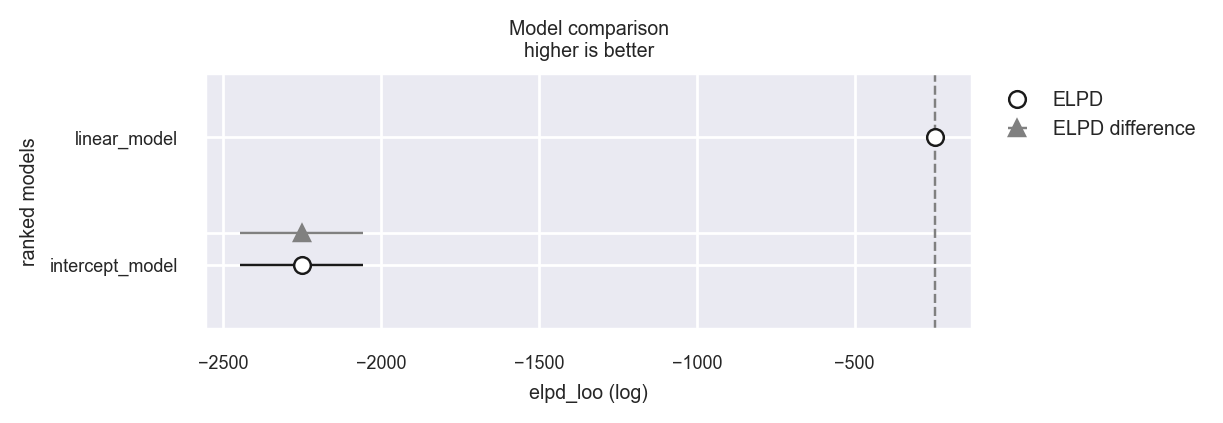

In [15]:
_ = az.plot_compare(df_comp_loo, insample_dev=False)

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jan 25 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

pymc       : 5.10.3
scipy      : 1.11.4
statsmodels: 0.14.1
numpy      : 1.26.2
pandas     : 2.1.4
matplotlib : 3.8.2
arviz      : 0.17.0
seaborn    : 0.13.0

Watermark: 2.4.3

